In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
import os
import random
import csv
from sys import platform
from IPython.core.display import HTML
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abir.deb/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def compute_stats(metric, df):
    '''
    compute mean, std, and % CV on a metric for each team's models;
    expects metric to be a string; df is a dataframe that contains the model metrics
    '''
    #compute metrics
    mean = df.pivot(index = 'team', columns = 'year', values = metric).mean(axis = 1)
    std = df.pivot(index = 'team', columns = 'year', values = metric).std(axis = 1)
    cv = std / mean * 100
    
    #return in a list
    to_return_lst = [mean.sort_values(), std.sort_values(), cv.sort_values()]
    
    return to_return_lst




def load_standings(filePath, year):
    '''
    loads standings data into a dataframe and returns it
    '''
    file_name = 'Regular_Season_Standings'
    full_path = filePath + str(year) + '_' + file_name + '.csv'
    df = pd.DataFrame.from_csv(full_path)
    
    #reset index
    df = df.reset_index()
    
    #add a column for year
    df['year'] = year
    
    #remove '*' and '+' from end of team names
    df.Tm = df.Tm.apply(str.strip, args = ('+')).apply(str.strip, args = '*')
        
    return df

*Let's read in the csv file with metric results for each team's models into a dataframe*

**3 models per team (a model each year, 2014-2016)**

In [3]:
#make sure directory paths are correct based on running in a Windows/Unix environment
if platform == 'win32':
    #code is running in a windows machine
    dir_files_to_load = os.getcwd() + '\\team_logistic_reg_results.csv'
    fp = os.getcwd() + '\\'
    stats_df_path = os.getcwd() + '\\nfl_savant_team_based_model_metrics_stats.csv'
    team_metrics_path = os.getcwd() + '\\team_metrics_vs_wins_losses.csv'
    df = pd.DataFrame.from_csv(filePath)
else:
    filePath = os.getcwd() + '/team_logistic_reg_results.csv'
    fp = os.getcwd() + '/'
    stats_df_path = os.getcwd() + '/nfl_savant_team_based_model_metrics_stats.csv'
    team_metrics_path = os.getcwd() + '/team_metrics_vs_wins_losses.csv'
    df = pd.DataFrame.from_csv(filePath)

In [4]:
df.head()

,year,team,acc_score_train_set,acc_score_test_set,cross_val_score,best_reg_par,acc_score_best_reg,precision,recall,f1_score,auc
0,2014,ARI,0.768506,0.802419,0.752313,0.1,0.806452,0.711538,0.804348,0.755102,0.854933
1,2014,ATL,0.769129,0.723320,0.733531,0.1,0.731225,0.580952,0.717647,0.642105,0.786555
2,2014,BAL,0.729659,0.708661,0.694118,10.0,0.712598,0.660714,0.678899,0.669683,0.793673
3,2014,BUF,0.735849,0.709677,0.718275,1.0,0.709677,0.683544,0.534653,0.600000,0.794167
4,2014,CAR,0.659151,0.678571,0.643196,100.0,0.674603,0.616162,0.580952,0.598039,0.713508


*What's the distribution of the precision, recall, f1 score, and AUC for all of the models irrespective 
of team and year?*

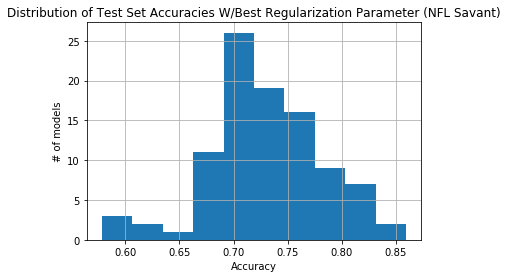

In [5]:
test_accuracy_best_reg_hist = plt.hist(df.acc_score_best_reg)
plt.title('Distribution of Test Set Accuracies W/Best Regularization Parameter (NFL Savant)')
plt.ylabel('# of models')
plt.xlabel('Accuracy')
plt.grid(True)
plt.show()

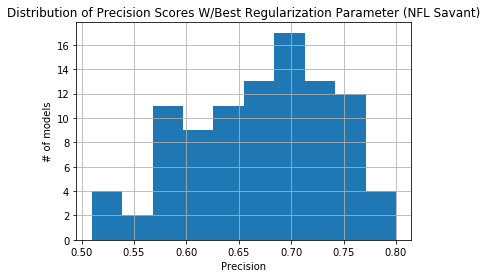

In [6]:
precision_hist = plt.hist(df.precision)
plt.title('Distribution of Precision Scores W/Best Regularization Parameter (NFL Savant)')
plt.ylabel('# of models')
plt.xlabel('Precision')
plt.grid(True)
plt.show()

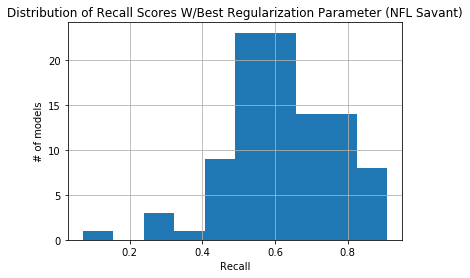

In [7]:
recall_hist = plt.hist(df.recall)
plt.title('Distribution of Recall Scores W/Best Regularization Parameter (NFL Savant)')
plt.ylabel('# of models')
plt.xlabel('Recall')
plt.grid(True)
plt.show()

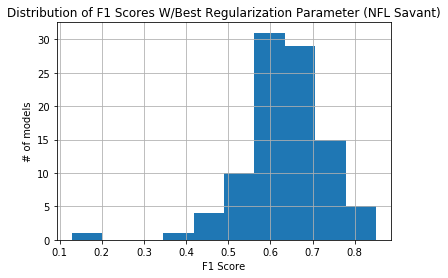

In [8]:
f1_score_hist = plt.hist(df.f1_score)
plt.title('Distribution of F1 Scores W/Best Regularization Parameter (NFL Savant)')
plt.ylabel('# of models')
plt.xlabel('F1 Score')
plt.grid(True)
plt.show()

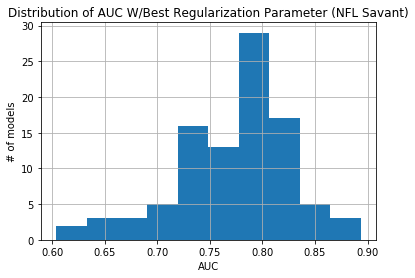

In [9]:
auc_hist = plt.hist(df.auc)
plt.title('Distribution of AUC W/Best Regularization Parameter (NFL Savant)')
plt.ylabel('# of models')
plt.xlabel('AUC')
plt.grid(True)
plt.show()

*What's the median precision, recall, f1 score, and AUC for each team's model?*

In [10]:
df.median()

year                   2015.000000
acc_score_train_set       0.748998
acc_score_test_set        0.725114
cross_val_score           0.731579
best_reg_par              1.000000
acc_score_best_reg        0.722869
precision                 0.679619
recall                    0.599065
f1_score                  0.637609
auc                       0.781582
dtype: float64

*What's the average precision, recall, f1 score, and AUC for each team's model?*

In [11]:
df.mean()

year                   2015.000000
acc_score_train_set       0.747507
acc_score_test_set        0.729666
cross_val_score           0.730819
best_reg_par              6.258344
acc_score_best_reg        0.729388
precision                 0.670761
recall                    0.618440
f1_score                  0.633003
auc                       0.772477
dtype: float64

*What's the standard deviation of the precision, recall, f1 score, and AUC for each team's model?*

In [12]:
df.std()

year                    0.820783
acc_score_train_set     0.040518
acc_score_test_set      0.052407
cross_val_score         0.044895
best_reg_par           19.967700
acc_score_best_reg      0.052166
precision               0.068300
recall                  0.146396
f1_score                0.101250
auc                     0.053430
dtype: float64

*What's the % CV for precision, recall, f1 score, and AUC for each team's model?*

In [13]:
df.std() / df.mean() * 100

year                     0.040734
acc_score_train_set      5.420443
acc_score_test_set       7.182312
cross_val_score          6.143162
best_reg_par           319.057266
acc_score_best_reg       7.152015
precision               10.182542
recall                  23.671746
f1_score                15.995244
auc                      6.916706
dtype: float64

*Do these metrics vary by year for each team or are they relatively consistent?*

**Gather accuracy, precision, recall, f1 score, and AUC stats**

In [14]:
acc_score_best_reg_means, acc_score_best_reg_std, acc_score_best_reg_cvs = compute_stats('acc_score_best_reg', df)
precision_means, precision_stds, precision_cvs = compute_stats('precision', df)
recall_means, recall_stds, recall_cvs = compute_stats('recall', df)
f1_means, f1_stds, f1_cvs = compute_stats('f1_score', df)
auc_means, auc_stds, auc_cvs = compute_stats('auc', df)

#explicit join of all data frames
all_stats_df = (
acc_score_best_reg_means.to_frame('acc_score_best_reg_means').join(acc_score_best_reg_std.to_frame(
'acc_score_best_reg_std')).join(acc_score_best_reg_cvs.to_frame('acc_score_best_reg_cvs')).join(
precision_means.to_frame('precision_means')).join(precision_stds.to_frame('precision_stds')).join(
precision_cvs.to_frame('precision_cvs')).join(recall_means.to_frame('recall_means')).join(
recall_stds.to_frame('recall_stds')).join(recall_cvs.to_frame('recall_cvs')).join(
f1_means.to_frame('f1_means')).join(f1_stds.to_frame('f1_stds')).join(f1_cvs.to_frame('f1_cvs')).join(
auc_means.to_frame('auc_means')).join(auc_stds.to_frame('auc_stds')).join(auc_cvs.to_frame('auc_cvs'))
)

#write model validation statistics results to csv file
all_stats_df.to_csv(stats_df_path)

**Mean accuracy scores with the best regularization parameter in each team's models**

In [15]:
acc_score_best_reg_means

team
BUF    0.635118
SF     0.663301
SEA    0.667494
PHI    0.676795
MIA    0.690097
NYJ    0.693054
CAR    0.693184
HOU    0.696993
OAK    0.702708
DEN    0.703898
KC     0.707177
ATL    0.712906
GB     0.718801
JAX    0.719394
BAL    0.720331
WAS    0.725032
LA     0.736746
SD     0.739584
CLE    0.739739
PIT    0.747363
CIN    0.748587
CHI    0.748591
IND    0.751400
ARI    0.752577
MIN    0.766981
NYG    0.769961
TB     0.770472
TEN    0.771090
DET    0.772524
NO     0.778426
NE     0.779981
DAL    0.840124
dtype: float64

**Standard deviation of accuracy scores with the best regularization parameter in each team's models**

In [16]:
acc_score_best_reg_std

team
GB     0.007342
MIA    0.009481
HOU    0.012733
NE     0.015794
DEN    0.016841
CAR    0.018432
NO     0.018794
TEN    0.019154
WAS    0.020381
BAL    0.022223
LA     0.023976
ATL    0.024829
NYJ    0.025143
CHI    0.025156
PIT    0.025641
KC     0.025837
DAL    0.028512
DET    0.029314
TB     0.032905
IND    0.033536
CIN    0.038403
SD     0.040456
JAX    0.044274
CLE    0.046341
ARI    0.046752
NYG    0.049025
PHI    0.051858
SEA    0.052874
BUF    0.065076
MIN    0.065271
OAK    0.065404
SF     0.074639
dtype: float64

**% CV (Coefficient of Variation) in accuracy scores with the best regularization parameter for each team's models**

In [17]:
 acc_score_best_reg_cvs

team
GB      1.021461
MIA     1.373934
HOU     1.826854
NE      2.024860
DEN     2.392529
NO      2.414351
TEN     2.484058
CAR     2.658962
WAS     2.811104
BAL     3.085106
LA      3.254361
CHI     3.360426
DAL     3.393731
PIT     3.430897
ATL     3.482792
NYJ     3.627889
KC      3.653583
DET     3.794577
TB      4.270812
IND     4.463115
CIN     5.130130
SD      5.470041
JAX     6.154310
ARI     6.212213
CLE     6.264570
NYG     6.367198
PHI     7.662323
SEA     7.921291
MIN     8.510054
OAK     9.307479
BUF    10.246279
SF     11.252633
dtype: float64

**Mean precision in each team's models**

In [18]:
precision_means

team
SF     0.575472
BUF    0.596310
ATL    0.605547
JAX    0.616038
DEN    0.619145
BAL    0.630532
CLE    0.631885
SEA    0.632970
MIA    0.636752
ARI    0.637717
TB     0.643050
HOU    0.647193
DET    0.651580
OAK    0.654647
NO     0.656517
WAS    0.656566
KC     0.663663
LA     0.669756
IND    0.673893
CAR    0.680684
SD     0.690685
PHI    0.692042
NYJ    0.702526
TEN    0.702946
NE     0.711393
GB     0.715533
PIT    0.716043
CIN    0.724647
CHI    0.730710
MIN    0.746229
NYG    0.765731
DAL    0.785934
dtype: float64

**Standard Deviation in precision for each team's models**

In [19]:
precision_stds

team
NYG    0.005808
DEN    0.011832
NYJ    0.013078
NE     0.014805
WAS    0.017495
DAL    0.019130
DET    0.020855
TEN    0.022396
MIN    0.025836
PIT    0.029993
KC     0.030401
CIN    0.038150
ATL    0.039360
LA     0.044688
CHI    0.049639
MIA    0.051813
GB     0.055625
CAR    0.058652
IND    0.062200
SF     0.063917
NO     0.064474
ARI    0.065066
BAL    0.065341
HOU    0.067748
CLE    0.073756
SEA    0.074631
PHI    0.078198
BUF    0.078906
JAX    0.082323
TB     0.082343
SD     0.088887
OAK    0.121751
dtype: float64

**% CV (Coefficient of Variation) in precision for each team's models**

In [20]:
precision_cvs

team
NYG     0.758547
NYJ     1.861541
DEN     1.911041
NE      2.081195
DAL     2.434029
WAS     2.664694
TEN     3.186064
DET     3.200609
MIN     3.462267
PIT     4.188664
KC      4.580829
CIN     5.264573
ATL     6.499907
LA      6.672224
CHI     6.793235
GB      7.773958
MIA     8.137151
CAR     8.616629
IND     9.229958
NO      9.820568
ARI    10.202884
BAL    10.362801
HOU    10.467903
SF     11.106917
PHI    11.299633
CLE    11.672301
SEA    11.790583
TB     12.805126
SD     12.869346
BUF    13.232430
JAX    13.363317
OAK    18.597979
dtype: float64

**Mean recall in each team's models**

In [21]:
recall_means

team
PHI    0.390841
MIA    0.399660
OAK    0.440330
GB     0.480756
CHI    0.530259
CAR    0.537606
KC     0.550849
SD     0.552348
BAL    0.560112
PIT    0.562644
JAX    0.564665
BUF    0.566432
IND    0.568373
NYJ    0.574230
CLE    0.594061
SEA    0.594715
DEN    0.609527
SF     0.616265
DET    0.616274
NYG    0.616385
HOU    0.641186
WAS    0.653666
CIN    0.654878
ATL    0.695780
TEN    0.704965
MIN    0.711895
LA     0.741801
NE     0.764681
ARI    0.780149
NO     0.792034
TB     0.847499
DAL    0.875216
dtype: float64

**Standard Deviation in recall for each team's models**

In [22]:
recall_stds

team
ARI    0.020960
NE     0.022055
TB     0.030758
PIT    0.034930
NYJ    0.035311
CAR    0.038187
ATL    0.038834
DAL    0.043289
BUF    0.046659
KC     0.047252
DEN    0.050978
NO     0.053232
GB     0.066678
CHI    0.068193
SEA    0.070847
SF     0.078223
IND    0.089112
CIN    0.091556
DET    0.097255
WAS    0.103939
TEN    0.108013
BAL    0.110723
LA     0.113077
HOU    0.113421
PHI    0.132378
SD     0.140532
JAX    0.145424
NYG    0.157752
CLE    0.163733
MIN    0.168410
OAK    0.174717
MIA    0.285638
dtype: float64

**% CV in recall for each team's models**

In [23]:
recall_cvs

team
ARI     2.686731
NE      2.884231
TB      3.629215
DAL     4.946061
ATL     5.581315
NYJ     6.149322
PIT     6.208186
NO      6.720889
CAR     7.103193
BUF     8.237396
DEN     8.363616
KC      8.578038
SEA    11.912793
SF     12.693099
CHI    12.860317
GB     13.869476
CIN    13.980613
LA     15.243539
TEN    15.321798
IND    15.678360
DET    15.781107
WAS    15.901003
HOU    17.689333
BAL    19.767984
MIN    23.656649
SD     25.442604
NYG    25.593047
JAX    25.754067
CLE    27.561696
PHI    33.870024
OAK    39.678640
MIA    71.470362
dtype: float64

**Mean f1 score in each team's models**

In [24]:
f1_means

team
MIA    0.437205
PHI    0.491007
OAK    0.515441
GB     0.574428
BUF    0.577021
JAX    0.577763
BAL    0.591328
SF     0.595144
CAR    0.598431
KC     0.600391
SD     0.608849
CLE    0.608918
SEA    0.610673
DEN    0.613212
CHI    0.614140
IND    0.616049
PIT    0.629302
DET    0.629577
NYJ    0.631736
HOU    0.639071
ATL    0.645969
WAS    0.652871
NYG    0.674839
CIN    0.687070
TEN    0.700512
LA     0.700916
ARI    0.701128
NO     0.716155
MIN    0.722737
TB     0.729720
NE     0.736802
DAL    0.827705
dtype: float64

**Standard Deviation in f1 score for each team's models**

In [25]:
f1_stds

team
ATL    0.004522
NE     0.006070
CAR    0.011004
KC     0.019097
PIT    0.019387
DEN    0.020499
BUF    0.020756
DAL    0.021190
NYJ    0.026821
NO     0.043450
DET    0.045262
ARI    0.047337
SEA    0.051794
TEN    0.054017
WAS    0.055575
TB     0.058777
LA     0.059824
CHI    0.063498
GB     0.063993
HOU    0.067022
CIN    0.068325
SF     0.070674
JAX    0.074327
IND    0.077229
BAL    0.083703
MIN    0.092892
NYG    0.100120
SD     0.103560
PHI    0.106125
CLE    0.119009
OAK    0.144095
MIA    0.269267
dtype: float64

**% CV in f1 score for each team's models**

In [26]:
f1_cvs

team
ATL     0.700088
NE      0.823794
CAR     1.838748
DAL     2.560122
PIT     3.080654
KC      3.180709
DEN     3.342832
BUF     3.597158
NYJ     4.245557
NO      6.067138
ARI     6.751537
DET     7.189344
TEN     7.711063
TB      8.054731
SEA     8.481388
WAS     8.512411
LA      8.535057
CIN     9.944427
CHI    10.339278
HOU    10.487374
GB     11.140326
SF     11.875125
IND    12.536214
MIN    12.852856
JAX    12.864680
BAL    14.155116
NYG    14.836144
SD     17.009137
CLE    19.544271
PHI    21.613841
OAK    27.955623
MIA    61.588334
dtype: float64

**Mean AUC in each team's models**

In [27]:
auc_means

team
PHI    0.696949
SF     0.697469
SEA    0.705316
MIA    0.705995
BUF    0.712839
OAK    0.714632
CAR    0.737577
HOU    0.738140
NYJ    0.754163
GB     0.761386
JAX    0.767620
CLE    0.768489
DEN    0.769638
KC     0.770548
BAL    0.774446
ATL    0.778046
CIN    0.780636
PIT    0.781143
WAS    0.781281
SD     0.781386
CHI    0.795448
TEN    0.797659
LA     0.800107
NYG    0.800339
IND    0.800437
NE     0.807214
ARI    0.807220
TB     0.814640
DET    0.817533
MIN    0.819769
NO     0.823426
DAL    0.857784
dtype: float64

**Standard Deviation in AUC for each team's models**

In [28]:
auc_stds

team
NO     0.009447
WAS    0.011363
TEN    0.015326
PIT    0.015685
IND    0.017558
HOU    0.020357
LA     0.020429
CHI    0.021499
DEN    0.022248
TB     0.023787
JAX    0.023869
ATL    0.024427
NYG    0.024755
CAR    0.024841
NE     0.028217
KC     0.029357
DET    0.029913
GB     0.036598
NYJ    0.039638
DAL    0.041394
PHI    0.044072
ARI    0.046851
SEA    0.047211
SD     0.047545
CIN    0.048592
BAL    0.048642
OAK    0.060454
MIN    0.063138
MIA    0.064622
BUF    0.070481
SF     0.081372
CLE    0.087051
dtype: float64

**% CV in f1 score for each team's models**

In [29]:
auc_cvs

team
NO      1.147306
WAS     1.454453
TEN     1.921311
PIT     2.007980
IND     2.193544
LA      2.553326
CHI     2.702703
HOU     2.757826
DEN     2.890761
TB      2.919888
NYG     3.093024
JAX     3.109429
ATL     3.139569
CAR     3.367933
NE      3.495649
DET     3.658899
KC      3.809879
GB      4.806777
DAL     4.825745
NYJ     5.255947
ARI     5.803944
SD      6.084708
CIN     6.224724
BAL     6.280873
PHI     6.323539
SEA     6.693593
MIN     7.701964
OAK     8.459397
MIA     9.153385
BUF     9.887317
CLE    11.327528
SF     11.666827
dtype: float64

*Are teams with better records more unpredictable in their play call versus teams that have worse records?*

In [30]:
years = [2014, 2015, 2016]
frames = [] #will hold dataframes with each year's regular season standings
for year in years:
    frames.append(load_standings(fp, year))
standings_df = pd.concat(frames)

In [31]:
standings_df.sort_values(by = 'W', ascending = False)

,DSRS,L,MoV,OSRS,PA,PD,PF,SRS,SoS,T,Tm,W,W-L%,year
24,2.1,1,12.0,6.0,308,192,500,8.1,-3.9,NaN,CAR,15,0.938,2015
0,5.0,2,11.9,4.3,250,191,441,9.3,-2.7,0.0,NE,14,0.875,2016
28,3.4,3,11.0,9.0,313,176,489,12.3,1.3,NaN,ARI,13,0.813,2015
16,2.9,3,7.2,4.1,306,115,421,7.0,-0.2,0.0,DAL,13,0.813,2016
0,3.5,4,9.7,7.5,313,155,468,10.9,1.3,0.0,NE,12,0.750,2014
12,0.4,4,8.0,9.2,354,128,482,9.6,1.6,0.0,DEN,12,0.750,2014
4,5.8,4,8.8,4.8,279,140,419,10.6,1.9,NaN,CIN,12,0.750,2015
0,1.7,4,9.4,5.3,315,150,465,7.0,-2.4,NaN,NE,12,0.750,2015
28,7.1,4,8.8,2.4,254,140,394,9.5,0.8,0.0,SEA,12,0.750,2014
12,4.4,4,4.9,1.2,311,78,389,5.6,0.7,0.0,KC,12,0.750,2016


In [32]:
#TO DO: Get rid of * and + in team names, then sum wins and losses and derive and Win % from them and find correlation
#between predictability of play calling and wins/win percentage or losses

In [33]:
standings_less_df = standings_df[['year', 'Tm', 'W', 'L']]

#aggregate Wins and Losses for all teams from 2014-2016
aggregate_standings_df = standings_less_df.groupby(by = ['Tm'])[['W', 'L']].sum()

#create a new column for Win Percentage
aggregate_standings_df['Win_Pct'] = aggregate_standings_df.W / (aggregate_standings_df.W + aggregate_standings_df.L) * 100
aggregate_standings_df['Win_Pct'] = aggregate_standings_df.Win_Pct.round(3)

#display standings in order of win percentage
aggregate_standings_df.sort_values('Win_Pct', ascending = False)

,W,L,Win_Pct
Tm,,,
NE,38,10,79.167
DEN,33,15,68.750
SEA,32,15,68.085
KC,32,16,66.667
PIT,32,16,66.667
GB,32,16,66.667
ARI,31,16,65.957
CIN,28,18,60.870
DAL,29,19,60.417


*Join all the metrics together into one dataframe*

In [34]:
metrics_df = (
            acc_score_best_reg_means
              .to_frame('acc_score_best_reg_means')
              .join(precision_means.to_frame('precision_means'))
              .join(recall_means.to_frame('recall_means'))
              .join(f1_means.to_frame('f1_means'))
                    .join(auc_means.to_frame('auc_means'))
             )

In [35]:
team_metrics = metrics_df.join(aggregate_standings_df)

**The correlation between model metrics and Wins, Losses, and Winning Percentage**

In [36]:
team_metrics.corr()

,acc_score_best_reg_means,precision_means,recall_means,f1_means,auc_means,W,L,Win_Pct
acc_score_best_reg_means,1.000000,0.625853,0.647821,0.750880,0.925634,0.035458,-0.030363,0.032098
precision_means,0.625853,1.000000,0.147461,0.433201,0.503480,0.203938,-0.203180,0.203193
recall_means,0.647821,0.147461,1.000000,0.939480,0.730250,0.043645,-0.049299,0.047170
f1_means,0.750880,0.433201,0.939480,1.000000,0.815649,0.111445,-0.117727,0.115202
auc_means,0.925634,0.503480,0.730250,0.815649,1.000000,0.049295,-0.043661,0.045373
W,0.035458,0.203938,0.043645,0.111445,0.049295,1.000000,-0.997883,0.999221
L,-0.030363,-0.203180,-0.049299,-0.117727,-0.043661,-0.997883,1.000000,-0.999655
Win_Pct,0.032098,0.203193,0.047170,0.115202,0.045373,0.999221,-0.999655,1.000000


*From the results above, Wins and Winning percentage do not correlate well with any of the model metrics, this means team play calling through logistic regression is not more predictable depending on how successful the team is during the season*

In [37]:
#write table to csv file
team_metrics.corr().to_csv(team_metrics_path)